 # UBC PM Sensor Calibration
Calibrate the UBC PM senors to the RAMP PM sensor using simple linear regression (MLR)

## Load python modules and set inputs

In [1]:
import context
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from sklearn import linear_model, feature_selection
from utils.pm import read_ramp
from context import data_dir


file_date = "220515"
ss = ["2022-05-15 14:58:00", "2022-05-15 15:56:00"]
# ss = ['2022-05-17 12:00:00', '2022-05-17 15:01:00']
# ubc_pms = ["%.2d" % i for i in range(1, 7)]
ubc_pms = ["01", "02", "04", "05", "06"]


******************************
context imported. Front of path:
/Users/rodell/Documents/Arduino
/Users/rodell/Documents/Arduino/docs/source
******************************

through /Users/rodell/Documents/Arduino/docs/source/context.py -- pha


## read data for the RAMP

In [2]:
ramp_pathlist = sorted(Path(str(data_dir) + f"/RAMP/").glob(f"{file_date}*.TXT"))
ramp_df = read_ramp(ramp_pathlist)
hours = pd.Timedelta("0 days 01:07:00")
ramp_df.index = ramp_df.index - hours
ramp_df = ramp_df.sort_index()[ss[0] : ss[1]]
ramp_df = ramp_df.resample("1Min").mean()

## read data for the UBC pm sensors

In [3]:

ubc_pathlist = np.ravel(
    [
        sorted(Path(str(data_dir) + f"/UBC-PM-{pm}/").glob(f"20{file_date}*.TXT"))
        for pm in ubc_pms
    ]
)


def read_ubcpm(path):
    path = str(path)
    print(path)
    df = pd.read_csv(path)
    del df["rtctime"]
    df["test"] = "20" + file_date + "T" + df["millis"]
    df["test"] = pd.to_datetime(df["test"])
    pm_date_range = pd.Timestamp("20" + file_date + "T" + path[-12:-4])
    diff = pm_date_range - df["test"][0]
    df["datetime"] = df["test"] + diff
    df = df.set_index(pd.DatetimeIndex(df["datetime"]))
    df = df.sort_index()[ss[0] : ss[1]]
    df = df.resample("1Min").mean()

    return df


ubc_dfs = [read_ubcpm(path) for path in ubc_pathlist]

/Users/rodell/Documents/Arduino/data/UBC-PM-01/20220515-14:41:26.TXT
/Users/rodell/Documents/Arduino/data/UBC-PM-02/20220515-14:45:40.TXT
/Users/rodell/Documents/Arduino/data/UBC-PM-04/20220515-14:51:17.TXT
/Users/rodell/Documents/Arduino/data/UBC-PM-05/20220515-14:52:08.TXT
/Users/rodell/Documents/Arduino/data/UBC-PM-06/20220515-14:54:02.TXT


## Plot time series
Plot timesires of the 1 min rolling average

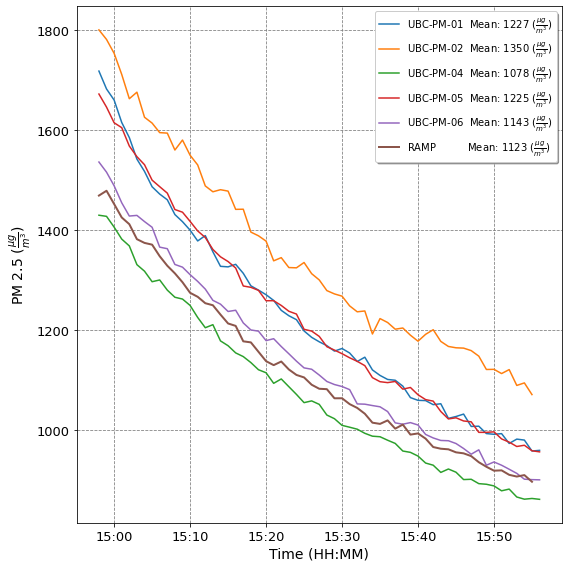

In [4]:
fig = plt.figure(figsize=(8, 8))  # (Width, height) in inches.
fig.autofmt_xdate()
ax = fig.add_subplot(1, 1, 1)
for i in range(len(ubc_dfs)):
    ax.plot(
        ubc_dfs[i].index,
        ubc_dfs[i]["pm25_env"],
        label=f'UBC-PM-{ubc_pms[i]}  Mean: {int(ubc_dfs[i]["pm25_env"].mean())}'
        + r" ($\frac{\mu g}{m^3}$)",
    )
ax.plot(
    ramp_df.index,
    ramp_df["pm25"],
    lw=2,
    label=f'RAMP          Mean: {int(ramp_df["pm25"].mean())}'
    + r" ($\frac{\mu g}{m^3}$)",
)
xfmt = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(xfmt)
ax.set_xlabel("Time (HH:MM)", fontsize=14)
ax.set_ylabel(r"PM 2.5 ($\frac{\mu g}{m^3}$)", fontsize=14)
ax.tick_params(axis="both", which="major", labelsize=13)
ax.xaxis.grid(color="gray", linestyle="dashed")
ax.yaxis.grid(color="gray", linestyle="dashed")
ax.legend(
    loc="upper right",
    # bbox_to_anchor=(0.48, 1.15),
    ncol=1,
    fancybox=True,
    shadow=True,
)
fig.tight_layout()



Combine PM 2.5 data for all senors (UBCs and RAMP)into one df
This dataframe will be use to create linear regression models for every ubc sensor

In [5]:

df = ramp_df.filter(["pm25"], axis=1)
for i in range(len(ubc_pms)):
    df[f"pm25_{ubc_pms[i]}"] = ubc_dfs[i]["pm25_env"]
df.head()

for i in range(len(ubc_pms)):
    print(np.unique(np.isnan(ubc_dfs[i]["pm25_env"]), return_counts=True))
    print(ubc_dfs[i].index[-1])

(array([False]), array([59]))
2022-05-15 15:56:00
(array([False]), array([58]))
2022-05-15 15:55:00
(array([False]), array([59]))
2022-05-15 15:56:00
(array([False]), array([59]))
2022-05-15 15:56:00
(array([False]), array([59]))
2022-05-15 15:56:00


### Pearson correlation
Solve Pearson correlation prior to linear regression
$$
r_{x y}=\frac{\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sqrt{\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)^{2}} \sqrt{\sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)^{2}}}
$$

In [6]:
pm_rs = []
for i in range(len(ubc_pms)):
    pm_r = round(df[f"pm25_{ubc_pms[i]}"].corr(df["pm25"]), 4)
    pm_rs.append(pm_r)
    print(f"Pearson correlation for (ubc_{ubc_pms[i]},ramp) = {pm_r}")

Pearson correlation for (ubc_01,ramp) = 0.9961
Pearson correlation for (ubc_02,ramp) = 0.9963
Pearson correlation for (ubc_04,ramp) = 0.9986
Pearson correlation for (ubc_05,ramp) = 0.9987
Pearson correlation for (ubc_06,ramp) = 0.9982



## Scatter plots
Make scatter plots of the data points for each pm sensor and plot the linear regression line in the scatter plots.

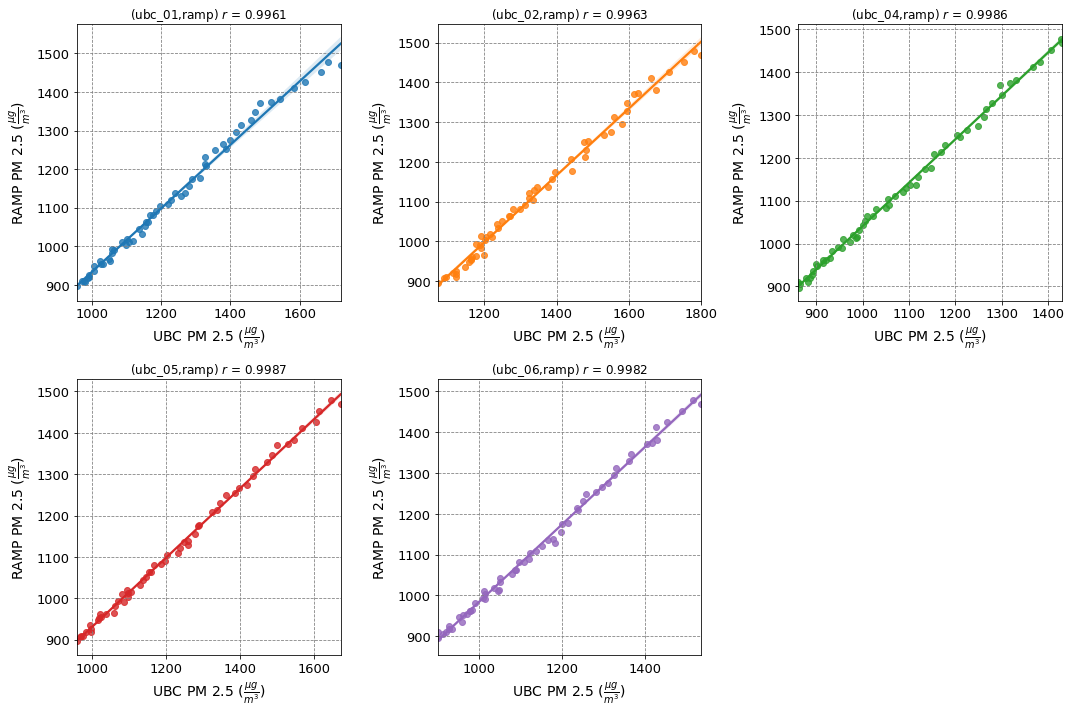

In [7]:
ny = len(ubc_pms) // 2
nx = len(ubc_pms) - ny
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig = plt.figure(figsize=(nx * 5, ny * 5))  # (Width, height) in inches.
for i in range(len(ubc_pms)):
    ax = fig.add_subplot(ny, nx, i + 1)
    sns.regplot(x=df[f"pm25_{ubc_pms[i]}"], y=df["pm25"], color=colors[i])
    ax.set_title(f"(ubc_{ubc_pms[i]},ramp) $r$ = {pm_rs[i]}")
    ax.set_ylabel(r"RAMP PM 2.5 ($\frac{\mu g}{m^3}$)", fontsize=14)
    ax.set_xlabel(r"UBC PM 2.5 ($\frac{\mu g}{m^3}$)", fontsize=14)
    ax.tick_params(axis="both", which="major", labelsize=13)
    ax.xaxis.grid(color="gray", linestyle="dashed")
    ax.yaxis.grid(color="gray", linestyle="dashed")
fig.tight_layout()

### Linear Regression
Normalize data and check it out

In [8]:
# df_norm = (df - df.mean())/df.std()
# df_norm.head()

Target variable: y; predictor variable(s): x

MLR results:
a0 = 107.01020933094469
a1 = 0.8255943625009389
MLR results:
a0 = -12.239445253744634
a1 = 0.8413829615623187
MLR results:
a0 = 25.801497218892337
a1 = 1.014699224230121
MLR results:
a0 = 95.76314424350699
a1 = 0.8357832389222485
MLR results:
a0 = 35.80729279946695
a1 = 0.9480784074865625


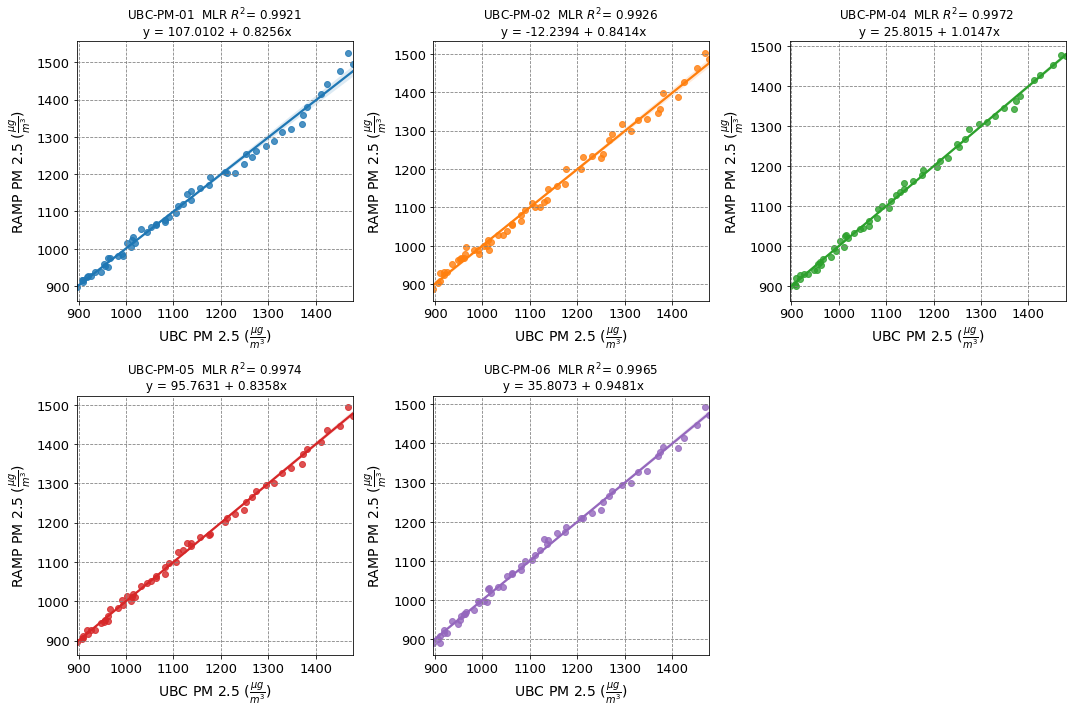

In [9]:


def make_mlr(i):
    X = df[f"pm25_{ubc_pms[i]}"].values[:, np.newaxis]
    y = df["pm25"].values
    lm_MLR = linear_model.LinearRegression()
    model = lm_MLR.fit(X, y)
    ypred_MLR = lm_MLR.predict(X)  # y predicted by MLR
    intercept_MLR = lm_MLR.intercept_  # intercept predicted by MLR
    coef_MLR = lm_MLR.coef_  # regression coefficients in MLR model
    R2_MLR = lm_MLR.score(X, y)  # R-squared value from MLR model

    print("MLR results:")
    print(f"a0 = {intercept_MLR}")

    coeff = {"a0": intercept_MLR}
    for j in range(len(coef_MLR)):
        coeff.update({f"a{j+1}": coef_MLR[j]})
        print(f"a{j+1} = {coef_MLR[j]}")
    if len(coeff) > 2:
        raise ValueError("This is a linear model, code only does single")
    else:
        pass
    ax = fig.add_subplot(ny, nx, i + 1)
    ax.set_ylabel(r"RAMP PM 2.5 ($\frac{\mu g}{m^3}$)", fontsize=14)
    ax.set_xlabel(r"UBC PM 2.5 ($\frac{\mu g}{m^3}$)", fontsize=14)
    ax.tick_params(axis="both", which="major", labelsize=13)
    ax.xaxis.grid(color="gray", linestyle="dashed")
    ax.yaxis.grid(color="gray", linestyle="dashed")
    sns.regplot(x=y, y=ypred_MLR, color=colors[i])
    # print(coeff)
    # print(coef_MLR)

    ax.set_title(
        f"UBC-PM-{ubc_pms[i]}  MLR "
        + r"$R^{2}$"
        + f"= {round(R2_MLR,4)} \n y = {round(coeff['a0'],4)} + {round(coeff['a1'],4)}x"
    )
    return


fig = plt.figure(figsize=(nx * 5, ny * 5))  # (Width, height) in inches.
for i in range(len(ubc_pms)):
    make_mlr(i)
fig.tight_layout()
